# Algorytmy Klasyfikacji - Analiza Datasetu Titanic



In [17]:
#pip install seaborn scikit-learn

In [18]:
# Importowanie bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteki do uczenia maszynowego
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Ładowanie i Wstępne Przetwarzanie Danych

In [19]:
# Ładowanie datasetu Titanic
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

print(df.head())
print(df.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [20]:
# Preprocessing danych
def preprocess_data(df):
    
    # 1. Usuwanie niepotrzebnych kolumn
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    
    # 2. Kodowanie zmiennych kategorycznych
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # 3. Obsługa brakujących wartości
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df = pd.get_dummies(df, columns=['Embarked'])
    

    # Po pierwszej iteracji przez zadania proszę zamienić to poniżej na 'return df'
    # i wtedy proszę poprawić x i y label w każdym z wykresów ponieważ wtedy będą czym innym
    # a dokładniej x będzie pierwszym predyktorem a y drugim
    
    return df



df_processed = preprocess_data(df)
print(df_processed.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0       3    0  22.0      1      0   7.2500       False       False   
1         1       1    1  38.0      1      0  71.2833        True       False   
2         1       3    1  26.0      0      0   7.9250       False       False   
3         1       1    1  35.0      1      0  53.1000       False       False   
4         0       3    0  35.0      0      0   8.0500       False       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


C:\Users\piotr\AppData\Local\Temp\ipykernel_11668\3862550864.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\piotr\AppData\Local\Temp\ipykernel_11668\3862550864.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

## Kod do późniejszej wizualizacji

In [21]:
from matplotlib.colors import ListedColormap

def plot_decision_boundaries(model, X, y, title, ax):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'blue')))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(('black', 'white')))
    ax.set_title(title)
    return scatter

def reduce_features(X_train, X_test):
    return X_train[:, :2], X_test[:, :2]

## Przygotowanie Danych do Klasyfikacji

In [22]:
def prepare_data(df):
    # Wybór cech i etykiet
    X = df.drop('Survived', axis=1)
    y = df['Survived']
    
    # Podział na zbiory treningowe i testowe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Wyodrębnienie kolumny 'Sex', która nie będzie skalowana
    X_train_sex = X_train['Sex'].values.reshape(-1, 1)
    X_test_sex = X_test['Sex'].values.reshape(-1, 1)
    
    # Usuwanie kolumny 'Sex' z cech do skalowania
    X_train_no_sex = X_train.drop('Sex', axis=1)
    X_test_no_sex = X_test.drop('Sex', axis=1)
    
    # Skalowanie pozostałych cech
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_no_sex)
    X_test_scaled = scaler.transform(X_test_no_sex)
    
    # Dołączenie nieskalowanej kolumny 'Sex'
    X_train_final = np.hstack((X_train_scaled, X_train_sex))
    X_test_final = np.hstack((X_test_scaled, X_test_sex))
    
    return X_train_final, X_test_final, y_train, y_test


X_train, X_test, y_train, y_test = prepare_data(df_processed)

# Do wizualizacji
X_train_reduced, X_test_reduced = reduce_features(X_train, X_test)

## Klasyfikacja - K-Nearest Neighbors (KNN)

In [23]:
# Funkcja klasyfikacji KNN
def knn_classification(X_train, X_test, y_train, y_test, n_neighbors=5):
    """
    Klasyfikacja KNN z możliwością dostosowania liczby sąsiadów.

    Args:
    X_train (ndarray): Zbiór treningowy cech.
    X_test (ndarray): Zbiór testowy cech.
    y_train (ndarray): Zbiór treningowy etykiet.
    y_test (ndarray): Zbiór testowy etykiet.
    n_neighbors (int): Liczba sąsiadów w KNN.

    Returns:
    model (KNeighborsClassifier): Wytrenowany klasyfikator KNN.
    y_pred (ndarray): Przewidywane etykiety dla zbioru testowego.
    """
    # 1. Stwórz klasyfikator KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # 2. Trenowanie modelu
    knn.fit(X_train, y_train)

    # 3. Przewidywanie
    y_pred = knn.predict(X_test)

    # 4. Ocena modelu
    print("KNN - Wyniki klasyfikacji:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return knn, y_pred

# Wywołanie funkcji
knn_model, y_pred_knn = knn_classification(X_train_reduced, X_test_reduced, y_train, y_test, n_neighbors=5)

KNN - Wyniki klasyfikacji:
Accuracy: 0.6871508379888268
              precision    recall  f1-score   support

           0       0.69      0.86      0.76       105
           1       0.69      0.45      0.54        74

    accuracy                           0.69       179
   macro avg       0.69      0.65      0.65       179
weighted avg       0.69      0.69      0.67       179



Text(0, 0.5, '')

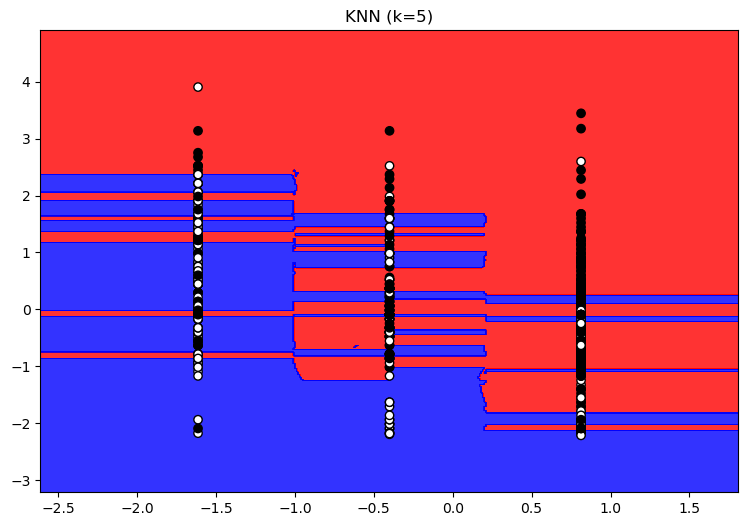

In [24]:
# Wizualizacja
knn_model.fit(X_train_reduced, y_train)
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
plot_decision_boundaries(knn_model, X_train_reduced, y_train, "KNN (k=5)", axes)
axes.set_xlabel('')
axes.set_ylabel('')

## Klasyfikacja - Support Vector Machines (SVM)

In [25]:
def svm_classification(X_train, X_test, y_train, y_test, kernels=['linear', 'rbf', 'poly'], C=1.0):
    """
    Klasyfikacja SVM z możliwością użycia wielu typów jąder.

    Args:
    X_train (ndarray): Zbiór treningowy cech.
    X_test (ndarray): Zbiór testowy cech.
    y_train (ndarray): Zbiór treningowy etykiet.
    y_test (ndarray): Zbiór testowy etykiet.
    kernels (list of str): Lista typów jąder do użycia w SVM (np. ['linear', 'rbf']).
    C (float): Parametr regularyzacji (domyślnie 1.0).

    Returns:
    dict: Słownik z modelami SVM (klucz to typ jądra, wartość to wytrenowany model).
    dict: Słownik z przewidywaniami SVM (klucz to typ jądra, wartość to przewidywania).
    """
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, classification_report

    # Przechowywanie modeli i przewidywań w słownikach
    svm_models = {}
    svm_predictions = {}

    for kernel in kernels:
        print(f"\nTrenowanie modelu SVM z jądrem: {kernel}")
        
        # 1. Stwórz klasyfikator SVM dla danego jądra
        svm = SVC(kernel=kernel, C=C)

        # 2. Trenowanie modelu
        svm.fit(X_train, y_train)

        # 3. Przewidywanie
        y_pred = svm.predict(X_test)

        # 4. Ocena modelu
        print(f"Wyniki klasyfikacji dla jądra: {kernel}")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy dla jądra {kernel}: {accuracy_score(y_test, y_pred)}")
        
        # Dodanie modelu i przewidywań do słowników
        svm_models[kernel] = svm
        svm_predictions[kernel] = y_pred

    return svm_models, svm_predictions

svm_models, svm_predictions = svm_classification(X_train_reduced, X_test_reduced, y_train, y_test, kernels=['linear', 'rbf', 'poly'], C=1.0)



Trenowanie modelu SVM z jądrem: linear
Wyniki klasyfikacji dla jądra: linear
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       105
           1       0.59      0.69      0.64        74

    accuracy                           0.68       179
   macro avg       0.67      0.68      0.67       179
weighted avg       0.69      0.68      0.68       179

Accuracy dla jądra linear: 0.6759776536312849

Trenowanie modelu SVM z jądrem: rbf
Wyniki klasyfikacji dla jądra: rbf
              precision    recall  f1-score   support

           0       0.73      0.90      0.80       105
           1       0.78      0.53      0.63        74

    accuracy                           0.74       179
   macro avg       0.75      0.71      0.72       179
weighted avg       0.75      0.74      0.73       179

Accuracy dla jądra rbf: 0.7430167597765364

Trenowanie modelu SVM z jądrem: poly
Wyniki klasyfikacji dla jądra: poly
              precision    recall

Text(0, 0.5, '')

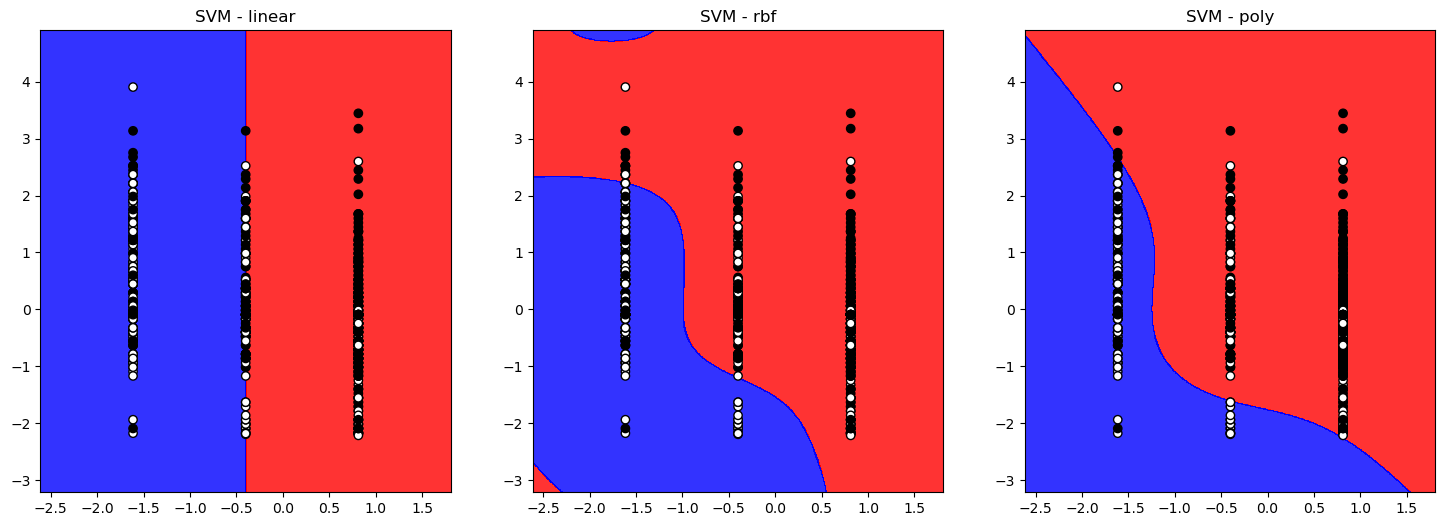

In [26]:
# Wizualizacja
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ind,[kernel,model] in enumerate(svm_models.items()):
    model.fit(X_train_reduced, y_train)
    plot_decision_boundaries(model, X_train_reduced, y_train, f"SVM - {kernel}", axes[ind])

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[0].set_ylabel('')

# Klasyfikacja DecisionTreeClassifier

In [27]:
def decision_tree_classification(X_train, X_test, y_train, y_test, max_depth=None, random_state=42):
    """
    Klasyfikacja z użyciem drzewa decyzyjnego.

    Args:
    X_train (ndarray): Zbiór treningowy cech.
    X_test (ndarray): Zbiór testowy cech.
    y_train (ndarray): Zbiór treningowy etykiet.
    y_test (ndarray): Zbiór testowy etykiet.
    max_depth (int): Maksymalna głębokość drzewa (domyślnie brak ograniczenia).
    random_state (int): Ziarno losowości dla powtarzalności wyników.

    Returns:
    model (DecisionTreeClassifier): Wytrenowany klasyfikator drzewa decyzyjnego.
    y_pred (ndarray): Przewidywane etykiety dla zbioru testowego.
    """
    # 1. Stwórz klasyfikator drzewa decyzyjnego
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)

    # 2. Trenowanie modelu
    dt.fit(X_train, y_train)

    # 3. Przewidywanie
    y_pred = dt.predict(X_test)

    # 4. Ocena modelu
    print("Decision Tree - Wyniki klasyfikacji:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
    return dt, y_pred

# Wywołanie funkcji
dt_model, y_pred_dt = decision_tree_classification(X_train_reduced, X_test_reduced, y_train, y_test, max_depth=3, random_state=42)

Decision Tree - Wyniki klasyfikacji:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       105
           1       0.72      0.55      0.63        74

    accuracy                           0.73       179
   macro avg       0.72      0.70      0.71       179
weighted avg       0.73      0.73      0.72       179

Accuracy: 0.7262569832402235


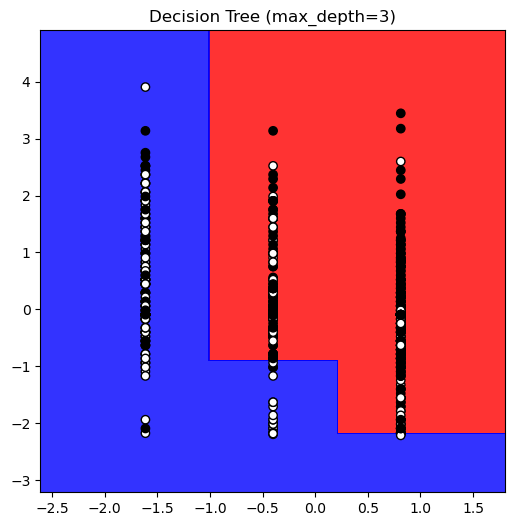

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_decision_boundaries(dt_model, X_train_reduced, y_train, "Decision Tree (max_depth=3)", ax)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

## Klasyfikacja Random Forest

In [29]:
def random_forest_classification(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    """
    Klasyfikacja z użyciem Random Forest.

    Args:
    X_train (ndarray): Zbiór treningowy cech.
    X_test (ndarray): Zbiór testowy cech.
    y_train (ndarray): Zbiór treningowy etykiet.
    y_test (ndarray): Zbiór testowy etykiet.
    n_estimators (int): Liczba estymatorów (drzew) w lesie. Domyślnie 100.
    random_state (int): Ziarno losowości dla powtarzalności wyników.

    Returns:
    rf (RandomForestClassifier): Wytrenowany klasyfikator Random Forest.
    y_pred (ndarray): Przewidywane etykiety dla zbioru testowego.
    """
    # 1. Stwórz klasyfikator
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # 2. Trenowanie modelu
    rf.fit(X_train, y_train)

    # 3. Przewidywanie
    y_pred = rf.predict(X_test)

    # 4. Ocena modelu
    print("\nRandom Forest - Wyniki klasyfikacji:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    return rf, y_pred

# Wywołanie funkcji
rf_model, y_pred_rf = random_forest_classification(X_train_reduced, X_test_reduced, y_train, y_test, n_estimators=150, random_state=42)


Random Forest - Wyniki klasyfikacji:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       105
           1       0.72      0.46      0.56        74

    accuracy                           0.70       179
   macro avg       0.71      0.67      0.67       179
weighted avg       0.71      0.70      0.69       179

Accuracy: 0.7039106145251397


Text(0, 0.5, '')

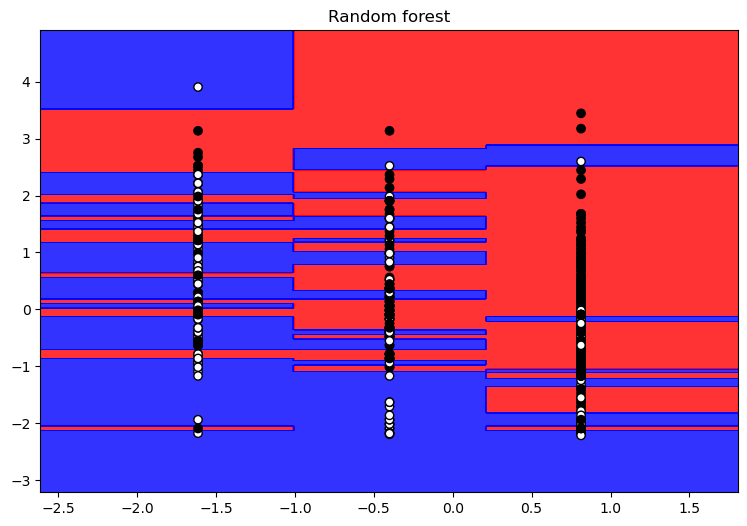

In [30]:
# Wizualizacja
rf_model.fit(X_train_reduced, y_train)
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
plot_decision_boundaries(rf_model, X_train_reduced, y_train, "Random forest", axes)
axes.set_xlabel('')
axes.set_ylabel('')

## Wizualizacja Porównawcza

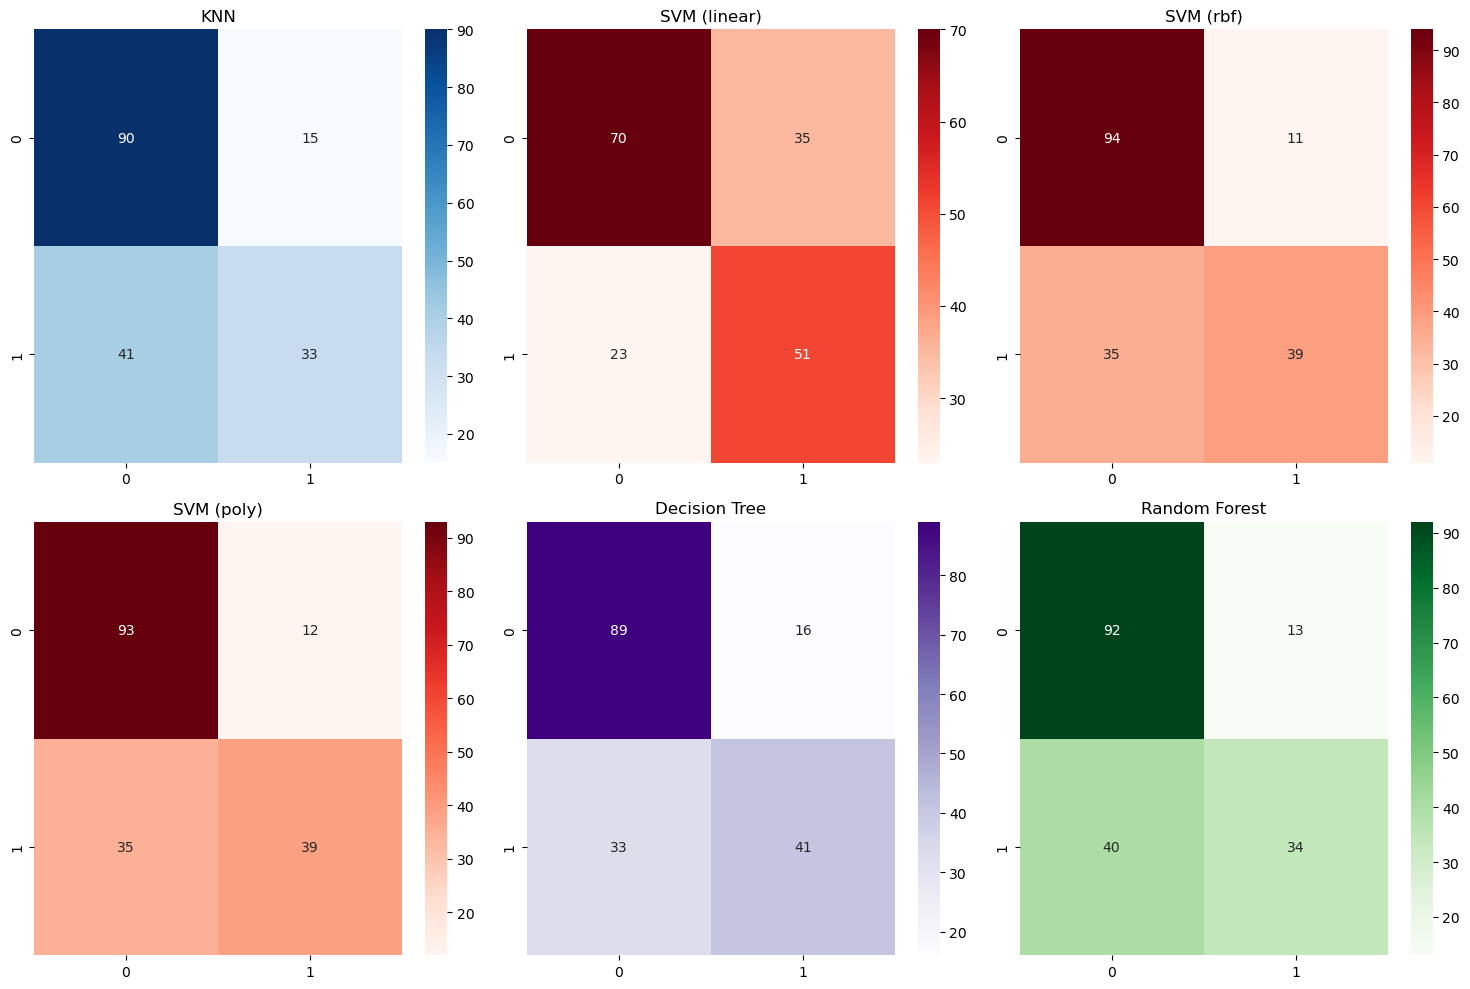

In [31]:
def compare_algorithms(y_test, y_pred_knn, svm_predictions, y_pred_rf,y_pred_dt):
    plt.figure(figsize=(15, 10))
    
    # Macierz pomyłek dla KNN
    plt.subplot(2, 3, 1)
    cm_knn = confusion_matrix(y_test, y_pred_knn)
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
    plt.title('KNN')
    
    # Macierze pomyłek dla SVM
    for idx, (kernel, y_pred_svm) in enumerate(svm_predictions.items()):
        plt.subplot(2, 3, idx+2)
        cm_svm = confusion_matrix(y_test, y_pred_svm)
        sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds')
        plt.title(f'SVM ({kernel})')

    # Macierz pomylek dla Decision Tree
    plt.subplot(2, 3, len(svm_predictions)+2)
    cm_dt = confusion_matrix(y_test, y_pred_dt)
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Purples')
    plt.title('Decision Tree')

    # Macierz pomyłek dla Random Forest
    plt.subplot(2, 3, len(svm_predictions)+3)
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
    plt.title('Random Forest')
    
    plt.tight_layout()
    plt.show()

# Wywołanie funkcji wizualizacyjnej
compare_algorithms(y_test, y_pred_knn, svm_predictions, y_pred_rf, y_pred_dt)

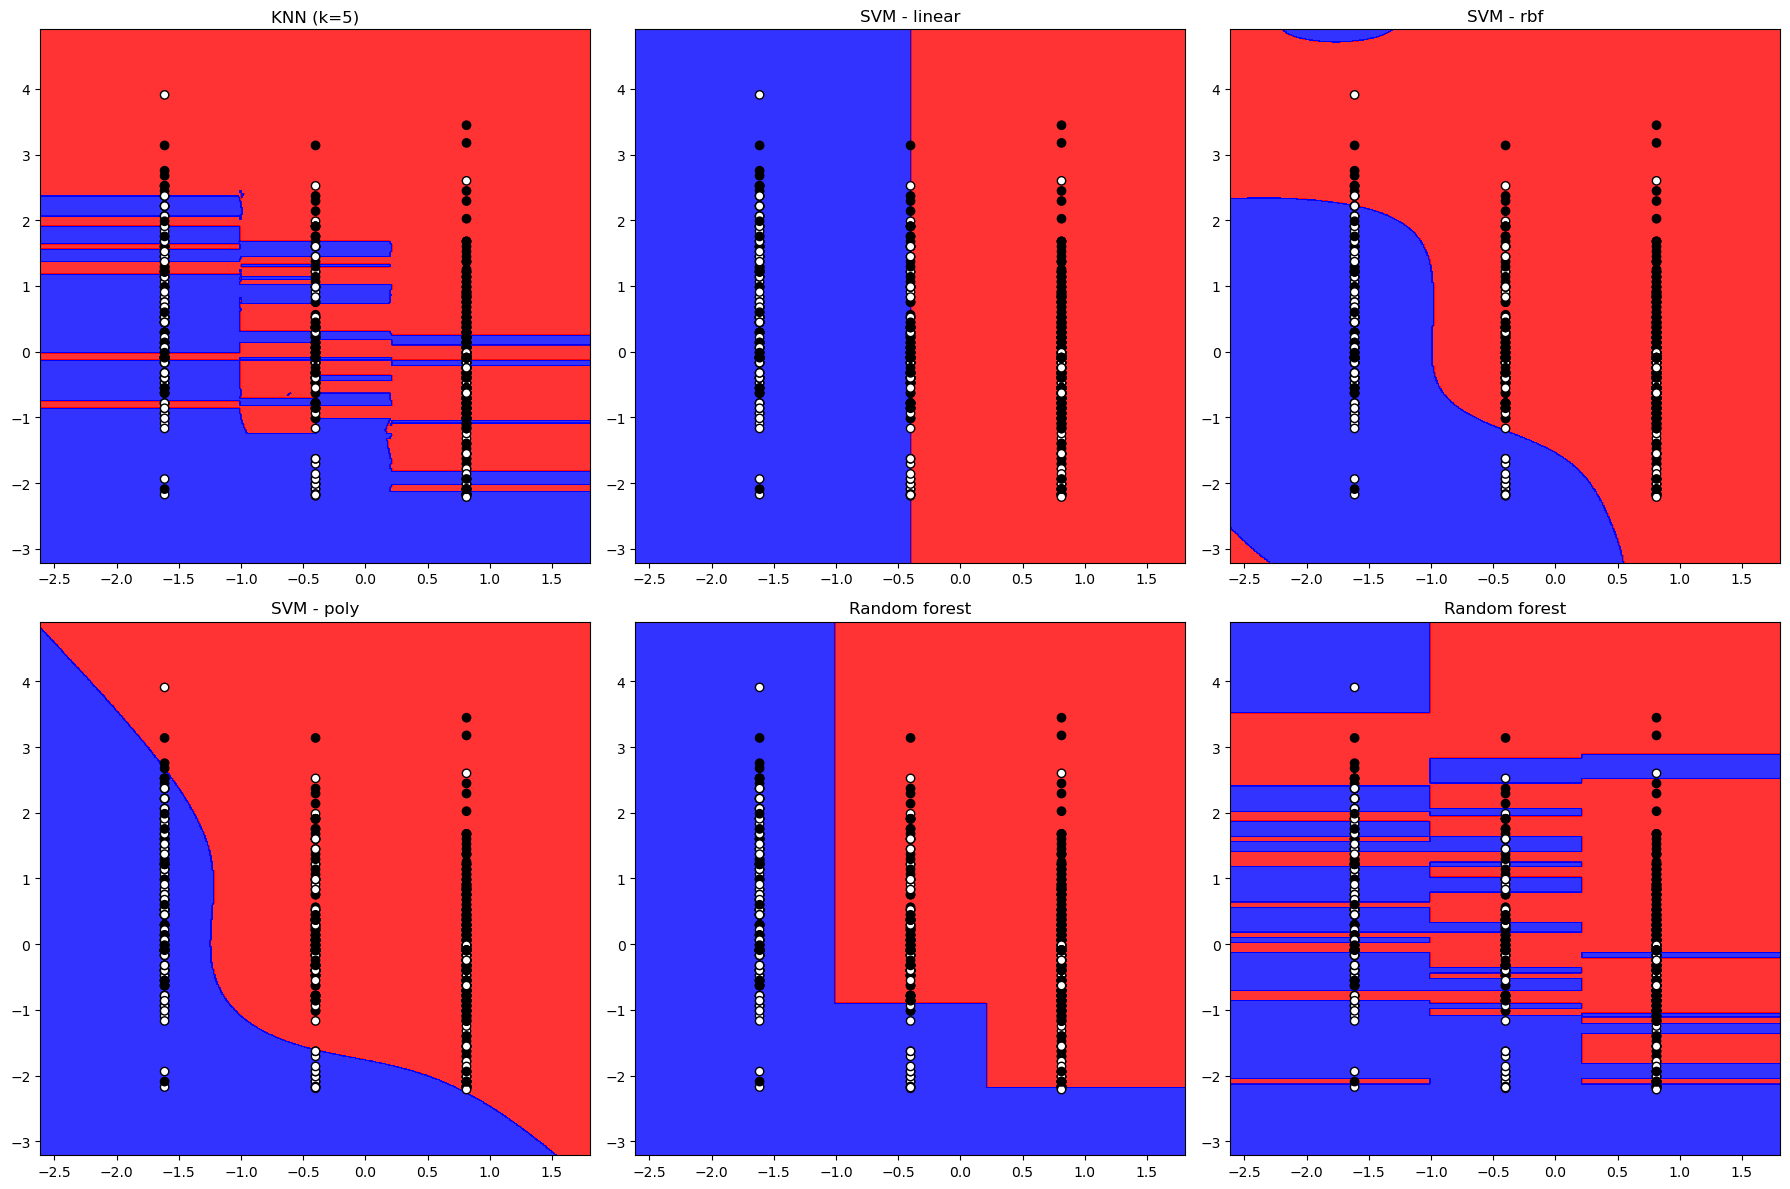

In [32]:
X_train_reduced, X_test_reduced = reduce_features(X_train, X_test)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# KNN
knn_model.fit(X_train_reduced, y_train)
plot_decision_boundaries(knn_model, X_train_reduced, y_train, "KNN (k=5)", axes[0])


# SVM z różnymi jądrami
for ind,[kernel,model] in enumerate(svm_models.items()):
    model.fit(X_train_reduced, y_train)
    plot_decision_boundaries(model, X_train_reduced, y_train, f"SVM - {kernel}", axes[ind+1])

# Decision Tree

dt_model.fit(X_train_reduced, y_train)
plot_decision_boundaries(dt_model, X_train_reduced, y_train, "Random forest", axes[4])


# Random Forest
rf_model.fit(X_train_reduced, y_train)
plot_decision_boundaries(rf_model, X_train_reduced, y_train, "Random forest", axes[5])



axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[4].set_xlabel('')

plt.tight_layout()
plt.show()
